In [111]:
'''
This is Riasat's version of CNN 
'''

import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision               # dataset download
import matplotlib.pyplot as plt
import cv2                       # openCV 
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [112]:
torch.cuda.is_available() # check gpu works or not

True

In [113]:
torch.version.cuda # check version 

'11.0'

In [114]:
# Our dataset

data_train = np.load('Data/data_train.npy').T      # dataset of 300 by 300images 
label_train =np.load('Data/labels_corrected.npy')  # labels
label_train=label_train.astype(int)
print(np.shape(data_train)) 
print(np.shape(label_train)) 

(6720, 90000)
(6720,)


In [115]:
label_name =np.array(['a','b','c','d','e','f','g','h','$','#'])

Index: [0 1 2 3 4 5 6 7 8 9]
Counts: [687 695 677 662 651 664 666 680 670 668]


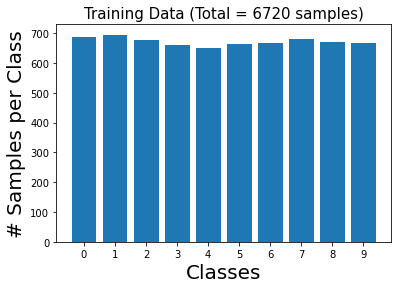

In [116]:
# Dataset 
# Counting number samples per class
vals, counts = np.unique(label_train, return_counts=True)
print('Index:', vals)
print('Counts:',counts)
plt.bar(vals, counts)
plt.xticks(range(10),range(10))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(data_train.shape[0])+' samples)',size=15);

In [117]:
print('data_train:', data_train)
print('label_train:',label_train)

data_train: [[161 162 162 ... 149 149 147]
 [162 162 162 ... 165 165 165]
 [195 195 195 ... 191 191 191]
 ...
 [195 195 195 ... 195 195 195]
 [158 157 157 ... 141 140 141]
 [149 149 150 ... 138 142 147]]
label_train: [8 8 1 ... 1 3 3]


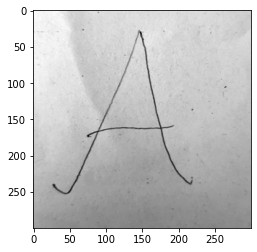

In [118]:
index=391
plt.imshow(data_train[index,:].reshape(300,300), cmap='gray') # see the how the data looks 

In [119]:
# function for morphological transformation 

def resize_func(input_data,new_width,new_height):#input the (1,90000) data
    size1 = np.shape(input_data)[0] 
    size2 = int(size1**(0.5))
    output = cv2.resize(input_data.reshape(size2,size2),(new_width,new_height))
    return output

def erosion(input_data,kernel, num_it):
    return cv2.erode(input_data,kernel,iterations=num_it) 
def dialtion(input_dat,kernel, num_it):
    return cv2.dilate(input_data,kernel,iterations=num_it)
def opening(input_data,kernel):
    return cv2.morphologyEx(input_data,cv2.MORPH_OPEN, kernel)
def closing(input_data, kernel):
    return cv2.morphologyEx(input_data, cv2.MORPH_CLOSE,kernel)
def morph_grad(input_data, kernel):
    return cv2.morphologyEx(input_dat, cv2.MORPH_GRADIENT, kernel)

def morph_trans(input_data, n_width, n_height, d_kernel, o_kernel,c_kernel):    # input 1 by 90000
    # inverse color 
    x_gray=1- input_data # inverse back to original with value 0 to 1
    #x_x=cv2.threshold(input_data,200,255,cv2.THRESH_BINARY_INV)
    #gray=cv2.erode(x_gray,d_kernel)
    #print(x_x.shape)
    x5 = np.where(x_gray <150,0,255)
    picture=x5
    return picture.reshape(1,-1)

def morph_ops(input_data,n_width,n_height):
    x0 = 1-input_data
    x0_1 = resize_func(x0,n_width,n_height)
    x1 = x0_1.reshape(n_width,n_height)
    x4 = np.clip(x1-np.mean(x1),0,1)
    x5 = np.where(x1 < 0.3,0,x4)
    dilate_kernel = np.ones((2,2),np.uint8)
    x6 = cv2.dilate(x5,dilate_kernel,iterations=1)
    x7 = np.where(x6<0.15,0,x6)
    x8 = normalize(x7.reshape(-1,1)).reshape(n_width,n_height)
    x9 = np.where(x8>0.2,1,x8)
    x10 = x9.reshape(1,-1)
    picture = x10
    return 

In [123]:
# morphological transformation 
n_width=50  # new width
n_height=50 # new height 

# initialize dataset 
x_train =np.zeros((np.shape(data_train)[0],n_width*n_height))

#kernel list
dilate_kernel = np.ones((2,2),np.uint8)
open_kernel = np.ones((2,2),np.uint8)
closed_kernel = np.ones((2,2),np.uint8)

# normalize between o and 1
xx=data_train.copy()

for ii in range(np.shape(x_train)[0]):
    newrow = morph_trans(xx[ii,:],n_width,n_height,dilate_kernel,open_kernel,closed_kernel)
    #newrow = morph_ops(x_gray[ii,:],n_width,n_height)
    newrow = newrow.reshape(1,-1)
    newrow = resize_func(newrow[0,:],50,50)
    #newrow = newrow.reshape(1,-1)
    x_train[ii,:] = newrow
X = x_train


error: OpenCV(4.5.4) ..\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) func != 0 in function 'cv::hal::resize'


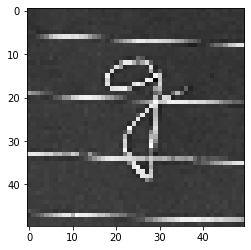

In [122]:
index = 5
x1 = X[index,:].reshape(50,50)
plt.imshow(x1,cmap='gray')

#x2=data_train[index,:].reshape(300,300)
#x2=cv2.morphologyEx(x2,cv2.MORPH_GRADIENT,dilate_kernel)
#plt.imshow(x2,cmap='gray')


##### hypermeters
EPOCH = 250
BATCH_SIZE = 50
LR = 0.001              # learning rate


In [9]:
torch.manual_seed(1)    # reproducible

# Hyperparameters
EPOCH = 1
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = False

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # padding
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (BATCH_SIZE, 32 * 7 * 7)
        output = self.out(x)
        return output, x


In [10]:
cnn = CNN()
print(cnn)  # print network architecture


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [23]:
X = 1-X_og.copy()

#kernel list
dilate_kernel = np.ones((2,2),np.uint8)
open_kernel = np.ones((3,3),np.uint8)
closed_kernel = np.ones((3,3),np.uint8)



X_new = np.zeros((np.shape(X_og)[0],50*50))
print(np.shape(X_og))
print(np.shape(X_new))
for ii in range(np.shape(X_new)[0]):
    newrow = morph_ops(X_og[ii,:])
    newrow = newrow.reshape(1,-1)
    newrow = resize_func(newrow[0,:],50,50)
    newrow = newrow.reshape(1,-1)
    X_new[ii,:] = newrow
print(np.shape(X_new))
X = X_new
X = 1-X

In [25]:
print(data.shape)
print(y.shape)

(6720, 90000)
(6720,)


1.3%

100.1%

Extracting ./mnist/MNIST\raw\train-images-idx3-ubyte.gz


18.4%%

Extracting ./mnist/MNIST\raw\train-labels-idx1-ubyte.gz


180.4%C:\Users\riasat\.conda\envs\data_science\lib\site-packages\torchvision\datasets\mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


Extracting ./mnist/MNIST\raw\t10k-images-idx3-ubyte.gz
Extracting ./mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...


C:\Users\riasat\.conda\envs\data_science\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\riasat\.conda\envs\data_science\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Done!
torch.Size([60000, 28, 28])
torch.Size([60000])


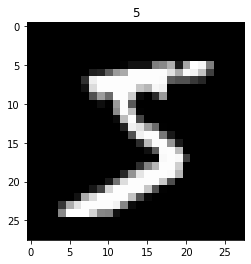

In [11]:

# Mnist digits dataset
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,
)

# Visualize the 1st picture in the training data
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()


In [12]:

# Data Loader for mini-batch return in training, the image batch shape will be (BATCH_SIZE, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # Normalization of test data: shape from (2000, 28, 28) to (2000, 1, 28, 28)
test_y = test_data.test_labels[:2000]  # test labels



optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # cross entropy loss



C:\Users\riasat\.conda\envs\data_science\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\riasat\.conda\envs\data_science\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [13]:

# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader

        output = cnn(b_x)[0]            # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


Epoch:  0 | train loss: 2.3125 | test accuracy: 0.18
Epoch:  0 | train loss: 0.4850 | test accuracy: 0.85
Epoch:  0 | train loss: 0.3738 | test accuracy: 0.90
Epoch:  0 | train loss: 0.3810 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2342 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1633 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0554 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1934 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0681 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0986 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0830 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0618 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0392 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0887 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0197 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0900 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2306 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0401 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0443 | test accuracy

In [14]:
# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print('Predicted number:', pred_y)
print('Real number: ', test_y[:10].numpy())

# save current model in an hdf5 file
model_dir = Path('THE DIRECTORY YOU WANT TO SAVE YOUR MODEL IN')
model_dir.mkdir(parents = True, exist_ok = True)
torch.save(cnn.state_dict(), model_dir.joinpath('cnn_pytorch.hdf5'))


Predicted number: [7 2 1 0 4 1 4 9 5 9]
Real number:  [7 2 1 0 4 1 4 9 5 9]
